In [1]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import osmnx as ox
import radar
from radar import RadarClient

initialize radar geofence object

In [2]:
SECRET_KEY = "prj_live_sk_df80bb59ade3340d72bf15933e50e2b8a5e34104"
radar = RadarClient(SECRET_KEY)

# create a geofence
data = {
    "description": "Example Store",
    "type": "circle",
    "coordinates": [-73.98706, 40.7041029],
    "radius": 100,
    "tag": "store",
    "externalId": "135",
}
new_geofence = radar.geofences.create(data=data)

functions that convert coordinates to address and vice versa

In [3]:
def convert_coord_to_address(G,mp):
    d = G.nodes[mp]
    address = radar.geocode.reverse(coordinates=(d['y'],d['x']))[0]
    return(address)
    
def convert_address_to_node(address,G):
    address = radar.geocode.forward(query=address)[0]
    min_dist = 1000000
    closest_node = 0
    for node in G.nodes:#search for closest node in graph G by coordinates
        node_data = G.nodes[node]
        dist = (node_data['y'] -address.latitude)**2 +(node_data['x'] -address.longitude)**2 
        if dist < min_dist:
            min_dist = dist
            closest_node = node
    #print(min_dist)
    return closest_node

function that finds best meeting point best on criteria

In [4]:
def get_mp(orig1,orig2,dest,G,G2,walking_more=False,get_to_dest_faster=True,min_dist_3 = 500):
    min_time = 1000000
    min_middle = -1
    if walking_more:#as of now the reduce gas means that the passanger has to walk more
        walk_limit = 2500
    else:
        walk_limit = 1000
    for i in range(len(list(G))):
        try:
            mp = list(G)[i]
            route1 = ox.shortest_path(G, orig1, mp, weight="travel_time")
            route2 = ox.shortest_path(G2, orig2, mp, weight="travel_time")
            route3 = ox.shortest_path(G, mp, dest, weight="travel_time")

            route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "travel_time")))
            route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G2, route2, "travel_time")))
            route3_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route3, "travel_time")))

            route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G2, route2, "length")))
            route3_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route3, "length")))
            if route2_length <= walk_limit and route3_length >= min_dist_3:
                # min_dist_3 makes sure that meeting point won't be somewhere extemely near destination point 
                if get_to_dest_faster:
                    total_time = max(route1_time, route2_time) + route3_time
                else:
                    total_time = max(route1_time ,route2_time)
                if total_time < min_time:
                    min_time = total_time
                    min_middle = mp
        except Exception as e:
            #print(e)
            pass
    print(min_middle,min_time)
    return min_middle

initialize graphs for osmnx

In [5]:
place = "Haifa, Israel"
G = ox.graph_from_place(place, network_type="drive")
Gp = ox.project_graph(G)

G2 = ox.graph_from_place(place, network_type="walk")
Gp2 = ox.project_graph(G2)

orig = list(G)[0]
dest = list(G)[120]

G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

G2 = ox.add_edge_speeds(G2)

# calculate travel time (seconds) for all edges
G2 = ox.add_edge_travel_times(G2)

get input from users

In [6]:
passanger_address = widgets.Text(value=" Leon Blum, Haifa")
driver_address = widgets.Text(value="Elisha street, Haifa")
destination_address = widgets.Text(value="Natanzon, Haifa")
dropdown_1 = widgets.Dropdown(options = ['walk less','gas reduce'])
dropdown_2 = widgets.Dropdown(options = ['get to destination faster','get to meeting point faster'])

d : Elisha street, Haifa, HA ISR , p : Leon Blum, Haifa, HA ISR, d: Natanzon, Haifa, HA ISR

In [7]:
display(driver_address,passanger_address,destination_address,dropdown_1,dropdown_2)

Text(value='Elisha street, Haifa')

Text(value=' Leon Blum, Haifa')

Text(value='Natanzon, Haifa')

Dropdown(options=('walk less', 'gas reduce'), value='walk less')

Dropdown(options=('get to destination faster', 'get to meeting point faster'), value='get to destination faste…

In [8]:
driver_address.value

'Elisha street, Haifa'

In [9]:
passanger_address.value

' Leon Blum, Haifa'

In [10]:
destination_address.value

'Natanzon, Haifa'

In [11]:
passanger_node = convert_address_to_node(passanger_address.value,G)

In [12]:
driver_node = convert_address_to_node(driver_address.value,G)

In [13]:
destination_node = convert_address_to_node(destination_address.value,G)

In [14]:
passanger_node,driver_node,destination_node

(308547607, 394924101, 779187086)

In [15]:
if dropdown_1.value == 'walk less':
    walking_more = False
else:
    walking_more = True
    
if dropdown_2.value == 'get to destination faster':
    get_to_dest_faster = True
else:
    get_to_dest_faster = False

In [16]:
walking_more,get_to_dest_faster

(False, True)

find meeting point and display routes and meeting point address

In [17]:
mp2 = get_mp(driver_node,passanger_node,destination_node,G,G2,walking_more=False,get_to_dest_faster=True,min_dist_3 = 500)

370888996 574


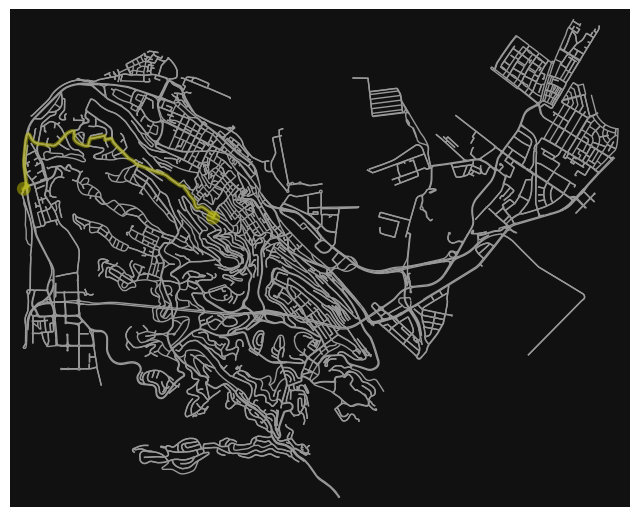

In [18]:
route = ox.shortest_path(G, driver_node, mp2, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=3, node_size=0)

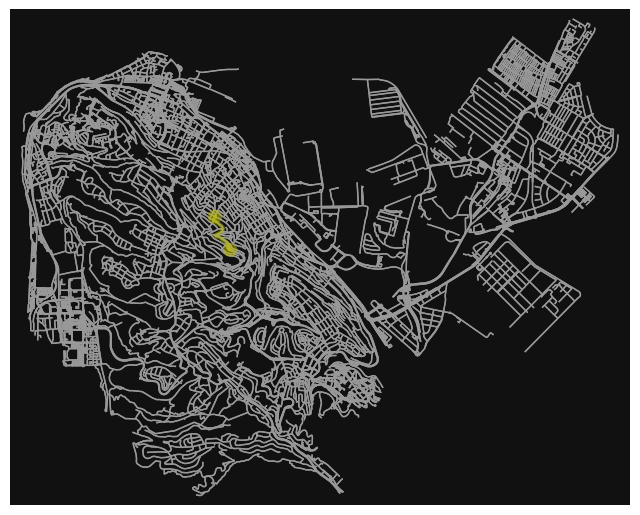

In [19]:
route = ox.shortest_path(G2, passanger_node, mp2, weight="travel_time")
fig, ax = ox.plot_graph_route(G2, route, route_color="y", route_linewidth=3, node_size=0)

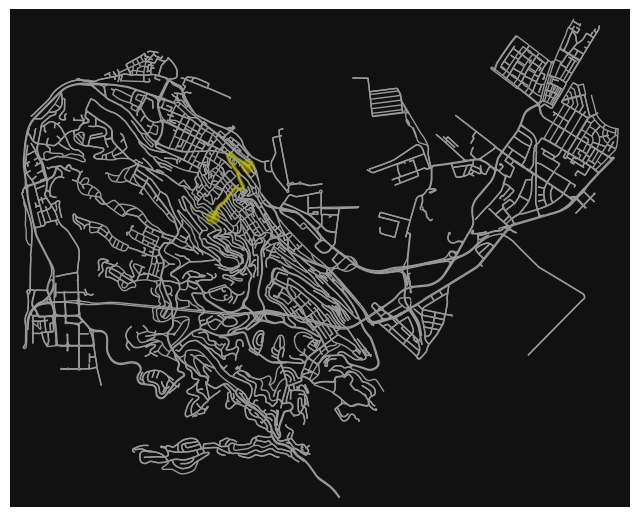

In [20]:
route = ox.shortest_path(G, mp2, destination_node, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=3, node_size=0)

In [21]:
convert_coord_to_address(G,mp2)

<Radar Address: latitude=32.807582 longitude=34.994853 formattedAddress='80 ארלוזורוב, Haifa, HA ISR'>